# Experimental Prediction : Logistic Regression

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

## Importing Data and Pre-processing

In [2]:
data_sim = pd.read_csv('data.txt',index_col=0)

# Adding Noise
np.random.seed(1)
for col in data_sim:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data_sim[col]))
        data_sim[col] = data_sim[col] + noise

# Remove Sim targets
data_sim.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_sim = data_sim.Contains_Crack
y2_sim = data_sim.Position_of_Crack
data_sim.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)

# Encoding targets
for idx in range(len(y1_sim)):
    if y1_sim[idx] == 'Yes':
        y1_sim[idx] = int(1)
    elif y1_sim[idx] == 'No': 
        y1_sim[idx] = int(0)
    
    if y2_sim[idx] == 'No Crack':
        y2_sim[idx] = int(0)
    elif y2_sim[idx] == 'Top Right':
        y2_sim[idx] = int(1)
    elif y2_sim[idx] == 'Top Left':
        y2_sim[idx] = int(2)
    elif y2_sim[idx] == 'Bottom Left':
        y2_sim[idx] = int(3)
    elif y2_sim[idx] == 'Bottom Right':
        y2_sim[idx] = int(4)
        
y1_sim = y1_sim.to_numpy(dtype=int)
y2_sim = y2_sim.to_numpy(dtype=int)

# Split the sim data into feature sets
X1_sim = data_sim
X2_sim = data_sim[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_sim[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_sim[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_sim[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_sim[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_sim[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_sim = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

data_sim.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,nf2,nf2_amp1,nf2_amp2,nf2_amp3,...,nf8_amp2,nf8_amp3,nf8_amp4,nf8_amp5,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,239.927829,0.024641,0.063642,-0.083850,...,0.115399,2.172240,-0.029574,0.416695,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,229.215934,0.033343,0.079914,0.645732,...,0.078016,2.183178,0.011719,0.074832,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,233.397982,0.162332,0.049100,-0.045416,...,0.253353,2.012175,0.230414,0.993327,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,231.460462,0.067496,0.064221,0.418760,...,0.283376,2.249152,0.412205,0.482657,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,236.767770,0.043564,0.044070,0.056621,...,-0.051874,2.148435,0.198727,0.079879,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
5,162.523635,1.047351,1.042740,-0.002253,1.061694,0.998956,241.820360,0.042069,0.065227,-0.040708,...,-0.074979,2.166130,0.021629,0.282718,843.228906,0.188047,0.081965,0.021252,-0.063861,0.012698
6,158.612786,1.032064,1.032980,0.072829,1.031189,1.217503,235.209321,0.063937,0.082172,0.398792,...,-0.087697,2.068172,-0.098057,0.617637,839.125209,0.191396,0.059224,0.136539,0.018024,0.137466


In [3]:
# Read Exp data
pd.set_option('display.max_columns', 12)
data_exp = pd.read_csv('experiment_data.txt',index_col=0)

# Remove Exp targets
data_exp.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_exp = data_exp.Contains_Crack
y2_exp = data_exp.Position_of_Crack
data_exp.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
    
# Split the Exp data into feature sets
X1_exp = data_exp
X2_exp = data_exp[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_exp[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_exp[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_exp[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_exp[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_exp[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_exp = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

# Encoding targets
for idx in range(len(y1_exp)):
    if y1_exp[idx] == 'Yes':
        y1_exp[idx] = int(1)
    elif y1_exp[idx] == 'No': 
        y1_exp[idx] = int(0)
    
    if y2_exp[idx] == 'No Crack':
        y2_exp[idx] = int(0)
    elif y2_exp[idx] == 'Top Right':
        y2_exp[idx] = int(1)
    elif y2_exp[idx] == 'Top Left':
        y2_exp[idx] = int(2)
    elif y2_exp[idx] == 'Bottom Left':
        y2_exp[idx] = int(3)
    elif y2_exp[idx] == 'Bottom Right':
        y2_exp[idx] = int(4)
        
y1_exp = y1_exp.to_numpy(dtype=int)
y2_exp = y2_exp.to_numpy(dtype=int)

data_exp.head(7)

C:\Users\James\AppData\Local\Temp/ipykernel_22464/1912993477.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_22464/1912993477.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y2_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_22464/1912993477.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(1)
C:\Users\James\AppData\Local\Temp/

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,170.0,15.58,1.14,0.358,4.930,3.49,...,900.0,92.1,58.9,7.67,41.1,46.3
1,170.0,14.90,14.10,0.615,5.090,14.80,...,880.0,155.0,166.0,17.40,18.4,162.0
2,165.0,4.56,3.95,0.709,7.255,4.04,...,915.0,52.1,39.6,5.02,92.1,40.8
3,157.5,4.87,7.75,0.519,3.370,4.23,...,877.5,47.2,76.1,6.36,14.2,18.8
4,162.5,7.34,0.82,0.433,9.540,3.12,...,910.0,166.0,76.0,7.52,182.0,82.5
5,160.0,1.88,13.46,0.625,4.200,6.01,...,897.5,32.1,238.0,13.40,46.1,92.5
6,160.0,4.78,1.64,0.432,5.980,3.44,...,892.5,19.6,57.6,6.64,18.0,70.6


In [4]:
# Mean Center the data
for col in X1_sim:
    X1_exp[col] = X1_exp[col]*((X1_sim[col].max())/(X1_exp[col].max())) - X1_sim[col].mean()
    X1_sim[col] = X1_sim[col] - X1_sim[col].mean()

for col in X2_sim:
    X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max())) - X2_sim[col].mean()
    X2_sim[col] = X2_sim[col] - X2_sim[col].mean()
    
for col in X3_sim:
    X3_exp[col] = X3_exp[col]*((X3_sim[col].max())/(X3_exp[col].max())) - X3_sim[col].mean()
    X3_sim[col] = X3_sim[col] - X3_sim[col].mean()

C:\Users\James\AppData\Local\Temp/ipykernel_22464/4078101616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max())) - X2_sim[col].mean()
C:\Users\James\AppData\Local\Temp/ipykernel_22464/4078101616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_sim[col] = X2_sim[col] - X2_sim[col].mean()


In [5]:
# Normalize the data
normalizer = Normalizer('l2')
X1_sim_norm = pd.DataFrame(normalizer.fit_transform(X1_sim))
X1_exp_norm = pd.DataFrame(normalizer.transform(X1_exp))
  
normalizer = Normalizer('l2')
X2_sim_norm = pd.DataFrame(normalizer.fit_transform(X2_sim))
X2_exp_norm = pd.DataFrame(normalizer.transform(X2_exp))

normalizer = Normalizer('l2')
X3_sim_norm = pd.DataFrame(normalizer.fit_transform(X3_sim))
X3_exp_norm = pd.DataFrame(normalizer.transform(X3_exp))

X1_sim_norm

,0,1,2,3,4,5,...,48,49,50,51,52,53
0,0.027235,-0.000163,0.000383,-0.000323,0.000347,-0.007422,...,0.110270,-0.000467,-0.000707,-0.001022,-0.000553,-0.002846
1,-0.013189,-0.000026,-0.000287,0.002183,-0.000090,-0.005039,...,-0.285412,0.010358,0.000175,0.001268,0.007920,0.003534
2,0.007638,0.003617,-0.000098,0.001072,-0.001689,-0.006790,...,-0.261187,-0.003489,0.004712,-0.000710,-0.000335,0.008749
3,-0.042777,-0.000330,0.000069,0.000673,0.000821,-0.012602,...,0.206885,-0.001966,0.002138,-0.004907,-0.003211,-0.005359
4,-0.011164,0.000218,-0.000789,-0.001211,-0.000158,-0.000784,...,0.038885,-0.002213,-0.005016,-0.000350,-0.003424,-0.001395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.016793,0.000323,-0.000905,-0.000319,0.000375,-0.007114,...,0.252828,-0.004616,-0.004912,-0.000788,-0.002406,-0.004783
96,-0.067375,-0.001052,0.003068,0.002160,0.000448,-0.014403,...,-0.313578,-0.001618,-0.000529,0.007708,0.006954,-0.003412
97,0.007619,-0.001503,-0.003635,-0.001380,0.000679,-0.015015,...,-0.489455,-0.014334,0.010338,-0.002142,0.008049,0.005049
98,0.038538,-0.001243,0.000277,0.000727,0.005157,-0.016513,...,0.084980,0.015774,0.007291,-0.001780,-0.002592,-0.004956


In [6]:
# Scaling
scaler = StandardScaler()
X1_sim_z = pd.DataFrame(scaler.fit_transform(X1_sim))
X1_exp_z = pd.DataFrame(scaler.transform(X1_exp))
  
scaler = StandardScaler()
X2_sim_z = pd.DataFrame(scaler.fit_transform(X2_sim))
X2_exp_z = pd.DataFrame(scaler.transform(X2_exp))

scaler = StandardScaler()
X3_sim_z = pd.DataFrame(scaler.fit_transform(X3_sim))
X3_exp_z = pd.DataFrame(scaler.transform(X3_exp))

X1_sim_z

,0,1,2,3,4,5,...,48,49,50,51,52,53
0,0.670126,-0.271328,0.441906,-0.357721,0.470944,-0.589413,...,0.792759,-0.128374,-0.240797,-0.550953,-0.158215,-0.813747
1,-0.295371,-0.039750,-0.301816,2.198194,-0.111713,-0.364197,...,-1.867551,2.591436,0.054319,0.621884,2.063030,0.919615
2,0.137632,4.400004,-0.082445,0.868148,-1.679804,-0.394895,...,-1.375184,-0.702298,1.175643,-0.280156,-0.070206,1.832113
3,-0.526526,-0.273796,0.039647,0.372117,0.557780,-0.500580,...,0.744020,-0.270266,0.364316,-1.323146,-0.459750,-0.766485
4,-0.225959,0.297414,-0.749635,-1.101999,-0.176404,-0.051194,...,0.229959,-0.500465,-1.405742,-0.155002,-0.805943,-0.328141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.352862,0.457513,-0.892273,-0.301291,0.435368,-0.482425,...,1.552236,-1.083680,-1.429066,-0.362930,-0.587914,-1.167972
96,-0.850177,-0.896019,1.816035,1.225408,0.312184,-0.586557,...,-1.156121,-0.228095,-0.092362,2.130742,1.020661,-0.500366
97,0.049765,-0.662505,-1.113789,-0.405264,0.244901,-0.316515,...,-0.934108,-1.045968,0.934991,-0.306457,0.611469,0.383248
98,0.475142,-1.034625,0.160000,0.402928,3.508475,-0.657060,...,0.306127,2.172672,1.244738,-0.480718,-0.371716,-0.709972


In [7]:
# PCS
pca = PCA()
X1_sim_PCS = pd.DataFrame(pca.fit_transform(X1_sim))
X1_exp_PCS = pd.DataFrame(pca.transform(X1_exp))
  
pca = PCA()
X2_sim_PCS = pd.DataFrame(pca.fit_transform(X2_sim))
X2_exp_PCS = pd.DataFrame(pca.transform(X2_exp))

pca = PCA()
X3_sim_PCS = pd.DataFrame(pca.fit_transform(X3_sim))
X3_exp_PCS = pd.DataFrame(pca.transform(X3_exp))

X1_sim_PCS

,0,1,2,3,4,5,...,48,49,50,51,52,53
0,-41.661411,-6.740434,1.582740,2.840217,-4.426129,1.179895,...,0.002903,0.003612,0.008418,0.010686,-0.017131,-0.010881
1,36.925512,4.021393,-10.137268,2.276493,2.124512,-3.355504,...,0.021345,0.029828,0.002259,-0.000362,-0.004747,0.002317
2,28.035125,-1.079336,-4.540772,10.552618,1.917972,1.118336,...,0.023951,0.011275,0.021848,0.017218,0.004592,-0.011512
3,-16.879112,1.764795,8.783189,-5.876034,-0.730296,-6.462446,...,-0.010425,-0.030283,-0.008611,-0.020792,0.012175,-0.006581
4,-34.611707,-1.693581,-0.792695,-0.198066,-1.914768,-3.743333,...,-0.023620,-0.014163,0.012563,-0.015253,-0.009436,-0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-34.269254,-10.530166,2.687978,-2.361154,2.013600,-3.354367,...,0.050420,-0.002025,-0.008738,0.011685,-0.004012,-0.002615
96,19.979123,5.280553,-0.105260,6.287136,-0.259130,1.422683,...,-0.018462,0.003321,0.010928,0.005167,0.000890,-0.017779
97,-0.434708,-5.854925,-1.532176,6.844333,-3.152001,3.412832,...,0.009751,0.005708,-0.012291,-0.000755,-0.016851,0.000066
98,-18.283160,-8.779468,-2.486299,3.774951,4.450404,-0.104277,...,0.010642,-0.024355,0.020540,0.013076,0.000407,0.014267


## No Scaling

Predicted values using x1 and y1: [0 1 0 1 0 0 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.6666666666666666 and AUC score of 0.75 



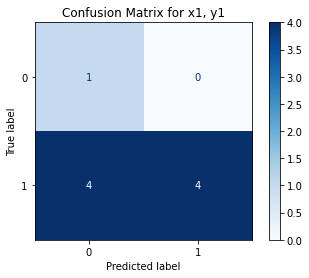

Predicted values using x2 and y1: [1 1 0 1 0 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.6666666666666666 and f1 score of: 0.7999999999999999 and AUC score of 0.375 



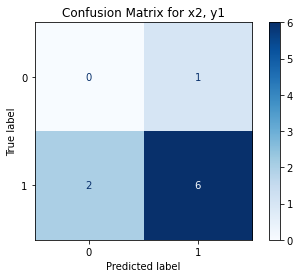

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



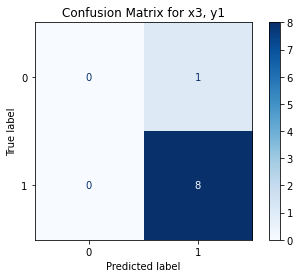

In [8]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_tree.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_tree.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_tree.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [4 1 1 4 4 1 4 4 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.2 and AUC score of 0.625 



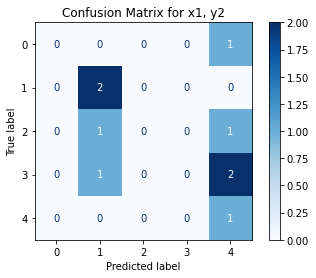

Predicted values using x2 and y2: [3 4 0 2 0 4 1 4 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.0 and f1 score of: 0.0 and AUC score of 0.37500000000000006 



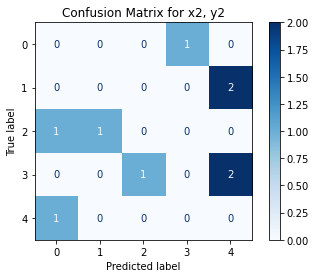

Predicted values using x3 and y2: [2 2 3 2 2 4 4 4 2]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.0 and f1 score of: 0.0 and AUC score of 0.375 



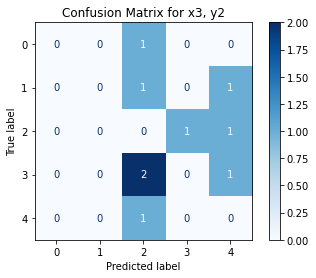

In [9]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_tree.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_tree.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_tree.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# Normalization

Predicted values using x1 and y1: [1 1 0 1 1 0 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.7142857142857143 and AUC score of 0.3125 



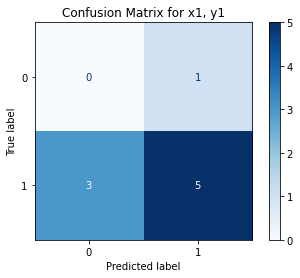

Predicted values using x2 and y1: [1 1 0 1 0 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.6666666666666666 and f1 score of: 0.7999999999999999 and AUC score of 0.375 



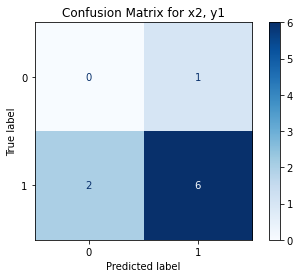

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



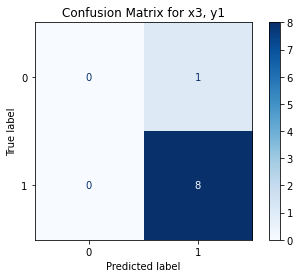

In [10]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X1_sim_norm, y1_sim)

x1y1_predict = x1y1_tree.predict(X1_exp_norm)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X1_exp_norm,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X2_sim_norm, y1_sim)

x2y1_predict = x2y1_tree.predict(X2_exp_norm)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X2_exp_norm,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X3_sim_norm, y1_sim)

x3y1_predict = x3y1_tree.predict(X3_exp_norm)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X3_exp_norm,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 4 1 4 0 4 4 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.14666666666666667 and AUC score of 0.5625 



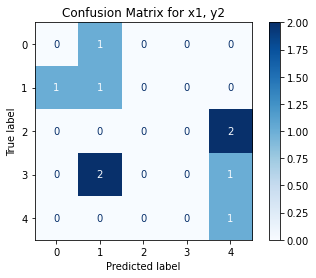

Predicted values using x2 and y2: [1 1 0 4 0 4 2 0 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.21333333333333332 and AUC score of 0.5000000000000001 



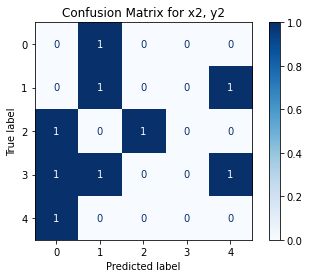

Predicted values using x3 and y2: [4 4 4 1 4 4 1 1 2]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.06666666666666668 and AUC score of 0.5 



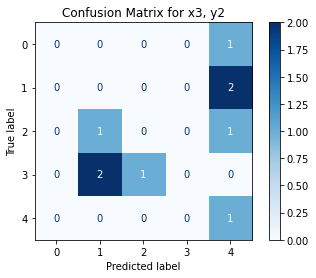

In [11]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X1_sim_norm, y2_sim)

x1y2_predict = x1y2_tree.predict(X1_exp_norm)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X1_exp_norm)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X1_exp_norm,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X2_sim_norm, y2_sim)

x2y2_predict = x2y2_tree.predict(X2_exp_norm)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X2_exp_norm)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X2_exp_norm,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X3_sim_norm, y2_sim)

x3y2_predict = x3y2_tree.predict(X3_exp_norm)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X3_exp_norm)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X3_exp_norm,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## Z Score Scaling

Predicted values using x1 and y1: [0 1 0 1 1 1 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.7777777777777778 and f1 score of: 0.8571428571428571 and AUC score of 0.875 



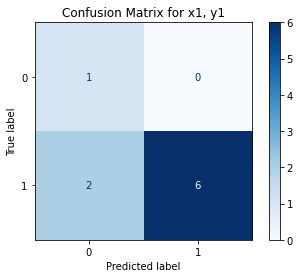

Predicted values using x2 and y1: [0 1 0 1 0 1 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.6666666666666666 and f1 score of: 0.7692307692307693 and AUC score of 0.8125 



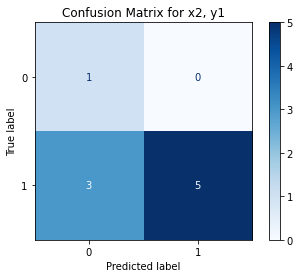

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



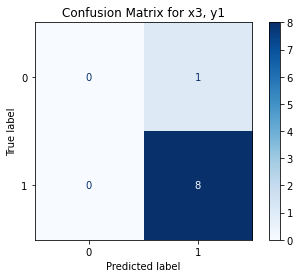

In [12]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X1_sim_z, y1_sim)

x1y1_predict = x1y1_tree.predict(X1_exp_z)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X1_exp_z,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X2_sim_z, y1_sim)

x2y1_predict = x2y1_tree.predict(X2_exp_z)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X2_exp_z,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X3_sim_z, y1_sim)

x3y1_predict = x3y1_tree.predict(X3_exp_z)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X3_exp_z,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [4 1 1 4 4 1 4 4 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.2 and AUC score of 0.625 



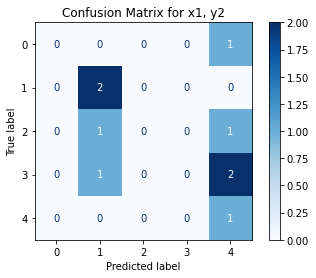

Predicted values using x2 and y2: [1 4 0 2 0 4 1 4 3]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.1 and AUC score of 0.41666666666666663 



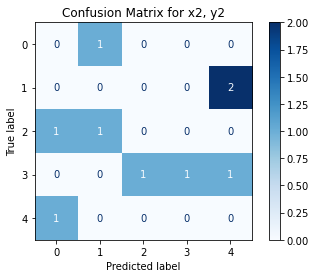

Predicted values using x3 and y2: [2 2 3 2 4 2 4 4 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.08 and AUC score of 0.5 



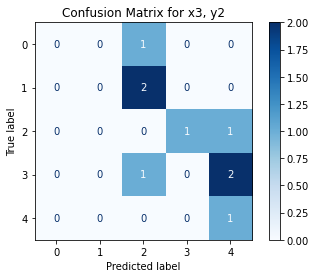

In [13]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X1_sim_z, y2_sim)

x1y2_predict = x1y2_tree.predict(X1_exp_z)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X1_exp_z)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X1_exp_z,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X2_sim_z, y2_sim)

x2y2_predict = x2y2_tree.predict(X2_exp_z)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X2_exp_z)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X2_exp_z,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X3_sim_z, y2_sim)

x3y2_predict = x3y2_tree.predict(X3_exp_z)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X3_exp_z)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X3_exp_z,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## PCS

Predicted values using x1 and y1: [0 1 1 1 1 1 1 1 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9333333333333333 and AUC score of 0.9375 



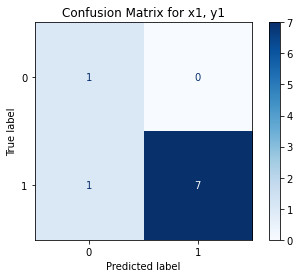

Predicted values using x2 and y1: [0 1 0 1 1 1 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.7777777777777778 and f1 score of: 0.8571428571428571 and AUC score of 0.875 



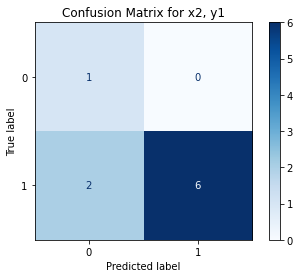

Predicted values using x3 and y1: [0 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



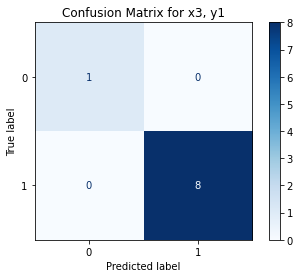

In [14]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X1_sim_PCS, y1_sim)

x1y1_predict = x1y1_tree.predict(X1_exp_PCS)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X1_exp_PCS,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X2_sim_PCS, y1_sim)

x2y1_predict = x2y1_tree.predict(X2_exp_PCS)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X2_exp_PCS,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X3_sim_PCS, y1_sim)

x3y1_predict = x3y1_tree.predict(X3_exp_PCS)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X3_exp_PCS,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [4 4 2 4 4 4 4 3 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.29047619047619044 and AUC score of 0.6041666666666666 



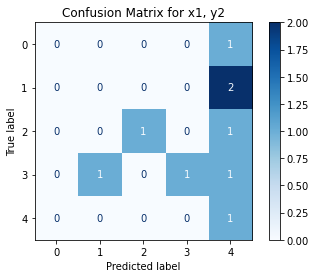

Predicted values using x2 and y2: [3 3 0 2 4 3 1 4 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.1 and AUC score of 0.5 



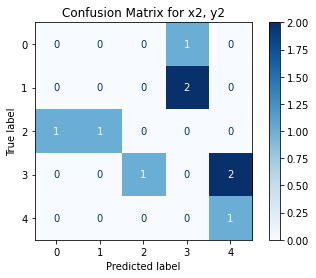

Predicted values using x3 and y2: [4 2 3 3 4 4 4 4 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.13714285714285715 and AUC score of 0.5416666666666667 



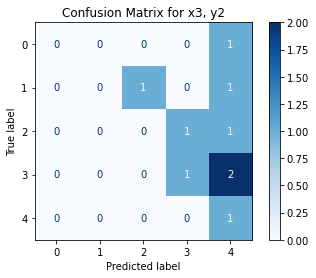

In [15]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X1_sim_PCS, y2_sim)

x1y2_predict = x1y2_tree.predict(X1_exp_PCS)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X1_exp_PCS)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X1_exp_PCS,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X2_sim_PCS, y2_sim)

x2y2_predict = x2y2_tree.predict(X2_exp_PCS)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X2_exp_PCS)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X2_exp_PCS,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X3_sim_PCS, y2_sim)

x3y2_predict = x3y2_tree.predict(X3_exp_PCS)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X3_exp_PCS)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X3_exp_PCS,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()